In [1]:
import torch
import torch.nn as nn
# import torch.optim as optim
import pytorch_lightning as pl
# import scipy
# import umap
import random
# import itertools
import tsl
import numpy as np
# import pandas as pd
# import networkx as nx
# import torch_geometric
# import lightning as L
import matplotlib.pyplot as plt

from tsl.datasets import PvUS
from tsl.data.datamodule import SpatioTemporalDataModule, TemporalSplitter
from tsl.data.preprocessing import StandardScaler
from tsl.metrics.torch import MaskedMAE
from tsl.engines import Predictor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from einops import rearrange
from tqdm import tqdm

# from dataset.NCI1_dataset import NCI1
# from tqdm import trange
# from sklearn.model_selection import train_test_split

from models.DynGraphESN import DynGESNModel

from DMD.dmd import KANN

seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


for more datasets:

https://github.com/dtortorella/dyngraphesn/tree/master

In [2]:
dataset = PvUS(root="dataset", zones=['west'])
print(dataset)

print(f"Default similarity: {dataset.similarity_score}")
print(f"Available similarity options: {dataset.similarity_options}")

sim = dataset.get_similarity("distance")  # or dataset.compute_similarity()

connectivity = dataset.get_connectivity(threshold=0.1,
                                        include_self=False,
                                        normalize_axis=1,
                                        layout="edge_index")

PvUS-west(length=52560, n_nodes=1082, n_channels=1)
Default similarity: distance
Available similarity options: {'distance', 'correntropy'}


In [3]:
horizon = 24

torch_dataset = tsl.data.SpatioTemporalDataset(target=dataset.dataframe(),
                                      connectivity=connectivity,
                                      mask=dataset.mask,
                                      horizon=horizon,
                                      window=254,
                                      stride=1)
print(torch_dataset)

SpatioTemporalDataset(n_samples=52283, n_nodes=1082, n_channels=1)


In [4]:
sample = torch_dataset[0].to(device)
print(sample)
print(sample.pattern)

Data(
  input=(x=[t=254, n=1082, f=1], edge_index=[2, e=124778], edge_weight=[e=124778]),
  target=(y=[t=24, n=1082, f=1]),
  has_mask=False
)
{'x': 't n f', 'edge_index': '2 e', 'edge_weight': 'e', 'y': 't n f'}


In [5]:
scalers = {'target': StandardScaler(axis=(0, 1))}

# Split data sequentially:
#   |------------ dataset -----------|
#   |--- train ---|- val -|-- test --|
splitter = TemporalSplitter(val_len=0.1, test_len=0.2)

dm = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    splitter=splitter,
    batch_size=1,
)

dm.setup()
print(dm)

SpatioTemporalDataModule(train_len=37391, val_len=3928, test_len=10456, scalers=[target], batch_size=1)


In [6]:
time_interval, num_nodes, feat_size = sample.input.x.shape
num_layers = 4
reservoir_size = 150

model = DynGESNModel(input_size=feat_size,
                reservoir_size=reservoir_size,
                input_scaling=0.4,
                reservoir_layers=num_layers,
                leaking_rate=0.5,
                spectral_radius=4.0,
                density=0.4,
                reservoir_activation='self_norm',
                alpha_decay=False).to(device)

In [8]:
sample.input

StorageView(x=[64, 1082, 1], edge_index=[2, 124778], edge_weight=[124778])

In [13]:
model(sample.input.x.unsqueeze(dim=0), sample.input.edge_index, sample.input.edge_weight).shape

torch.Size([1, 1082, 600])

In [8]:
sample.target

StorageView(y=[24, 1082, 1])

In [7]:
class LinearRegression(pl.LightningModule):
    def __init__(self, encoder, input_size, output_size):
        super().__init__()
        self.output_size = output_size
        self.encoder = encoder
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x, edge_index, edge_weight):
        z = self.encoder(x, edge_index, edge_weight)
        b, n, f = z.shape
        # z = rearrange(z, 'b n f -> b n f', n=n)
        new_x = self.linear(z)
        new_x = rearrange(new_x, 'b n f -> f n b', n=n, f=self.output_size)

        return new_x

In [8]:
forecaster = LinearRegression(model, input_size=reservoir_size*num_layers, output_size=feat_size*horizon).to(device)

In [18]:
loss_fn = MaskedMAE()

metrics = {'mae': MaskedMAE()}

# setup predictor
predictor = Predictor(
    model=forecaster,              # our initialized model
    optim_class=torch.optim.Adam,  # specify optimizer to be used...
    optim_kwargs={'lr': 0.07},    # ...and parameters for its initialization
    loss_fn=loss_fn,               # which loss function to be used
    metrics=metrics                # metrics to be logged during train/val/test
)

logger = TensorBoardLogger(save_dir="logs", name="dynGESN", version=0)
# %load_ext tensorboard
# %tensorboard --logdir logs

checkpoint_callback = ModelCheckpoint(
    dirpath='logs',
    save_top_k=1,
    monitor='val_mae',
    mode='min',
)
early_stop_callback = EarlyStopping(monitor="val_mae", min_delta=0.01, patience=3, verbose=False, mode="max")

trainer = pl.Trainer(
                    max_epochs=15,
                    logger=logger,
                    profiler="simple",
                    # limit_train_batches=0.1, 
                    limit_val_batches=0.01,
                    devices=1, 
                    accelerator="gpu" if torch.cuda.is_available() else "cpu",
                    limit_train_batches=10,  # end an epoch after 10 updates
                    callbacks=[checkpoint_callback, early_stop_callback])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [19]:
trainer.fit(predictor, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | MaskedMAE        | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | LinearRegression | 172 K 
---------------------------------------------------
14.4 K    Trainable params
158 K     Non-trainable params
172 K     Total params
0.691     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

Only args ['edge_index', 'edge_weight', 'x'] are forwarded to the model (LinearRegression). 


Epoch 0:   0%|          | 16/3739 [00:25<1:39:44,  0.62it/s, v_num=0]
                                                                           

c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\pytorch_lightning\loops\fit_loop.py:293: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 3: 100%|██████████| 10/10 [00:18<00:00,  0.53it/s, v_num=0, val_mae=23.40, train_mae=18.10]

FIT Profiler Report

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                              	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                               	|  -              	|  4442 

In [20]:
torch.save(forecaster.state_dict(), "models/dynGESN.pt")

In [21]:
# Specify the path to the saved model
model_path = "models/dynGESN.pt"

# Create an instance of the LinearRegression model
loaded_model = LinearRegression(model, input_size=reservoir_size*num_layers, output_size=feat_size*horizon).to(device)

# Load the saved model state_dict
loaded_model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
loaded_model.eval()


LinearRegression(
  (encoder): DynGESNModel(
    (reservoir): DynGraphESN(
      (rnn_cells): ModuleList(
        (0-3): 4 x GESNLayer()
      )
    )
  )
  (linear): Linear(in_features=600, out_features=24, bias=True)
)

In [16]:
test_sample = next(iter(dm.test_dataloader())).to(device)
output = loaded_model(test_sample.input.x, test_sample.input.edge_index, test_sample.input.edge_weight)

In [ ]:
outputs = []
targets = []

for test_sample in tqdm(dm.test_dataloader()):
    test_sample = test_sample.to(device)
    output = loaded_model(test_sample.input.x, test_sample.input.edge_index, test_sample.input.edge_weight).squeeze()

    outputs.append(output)
    targets.append(test_sample.target.y)
    if len(outputs) >= 100:
        break

stacked_outputs = torch.stack(outputs, dim=0)
stacked_targets = torch.stack(targets, dim=0)

In [15]:
stacked_outputs.shape

torch.Size([100, 24, 1082])

In [21]:
stacked_targets.shape

torch.Size([100, 1, 24, 1082, 1])

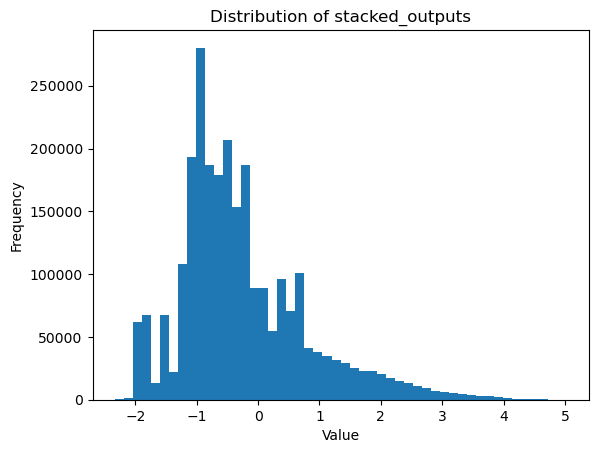

In [12]:
plt.hist(stacked_outputs.flatten().cpu().detach().numpy(), bins=50)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of stacked_outputs')
plt.show()


In [22]:
nonzero_indices = torch.nonzero(stacked_targets[:, 0, :, :, 0])
print(nonzero_indices)

tensor([[ 18,  23, 181],
        [ 18,  23, 193],
        [ 18,  23, 211],
        ...,
        [ 99,  12, 929],
        [ 99,  12, 931],
        [ 99,  13, 924]], device='cuda:0')


In [27]:
stacked_targets[99, 0,:,929,0]

tensor([20.3000, 19.9500, 19.9500, 19.3500, 18.8000, 18.2000, 17.0500, 15.6500,
        14.5500, 13.4000, 10.4500,  6.2500,  1.8500,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
       device='cuda:0')

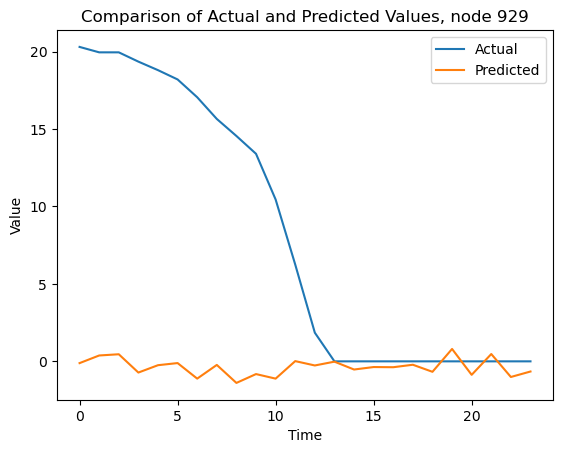

In [28]:
node_id = 929

plt.plot(stacked_targets[99,0,:,node_id,0].cpu().detach().numpy(), label='Actual')
plt.plot(stacked_outputs[99,:,node_id].cpu().detach().numpy(), label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Comparison of Actual and Predicted Values, node {node_id}')
plt.show()